In [3]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import numpy as np
import random
from transformers import CLIPProcessor, CLIPModel
import gc
from tqdm import tqdm 
import gdown

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
# define a transformation to convert images to Torch tensors
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.Caltech101(root='./data', transform=transform, download=True)
# randomly split the dataset into training and test sets
train_dataset, test_dataset = random_split(dataset, [int(.95*len(dataset)), len(dataset)-int(.95*len(dataset))])
print(f'training images: {len(train_dataset)}, test images: {len(test_dataset)}')

training images: 8243, test images: 434


In [5]:
# extract the images and labels from the dataset objects
# at the same time, we will discard all images that do
# not contain 3-channel RGB data, ensuring images are
# compatible with the CLIP model
train_images = [train_dataset[i][0] for i in range(len(train_dataset)) if train_dataset[i][0].shape[0] == 3]
train_labels = [train_dataset[i][1] for i in range(len(train_dataset)) if train_dataset[i][0].shape[0] == 3]
test_images = [test_dataset[i][0] for i in range(len(test_dataset)) if test_dataset[i][0].shape[0] == 3]
test_labels = [test_dataset[i][1] for i in range(len(test_dataset)) if test_dataset[i][0].shape[0] == 3]
print(f'training images: {len(train_images)}, test images: {len(test_images)}')
# make a copy of the list of categories
categories = dataset.categories.copy()
print(f'number of categories: {len(categories)}')
# free the memory used by the dataset objects
del dataset, train_dataset, test_dataset
gc.collect()

training images: 7886, test images: 410
number of categories: 101


20

<function matplotlib.pyplot.show(close=None, block=None)>

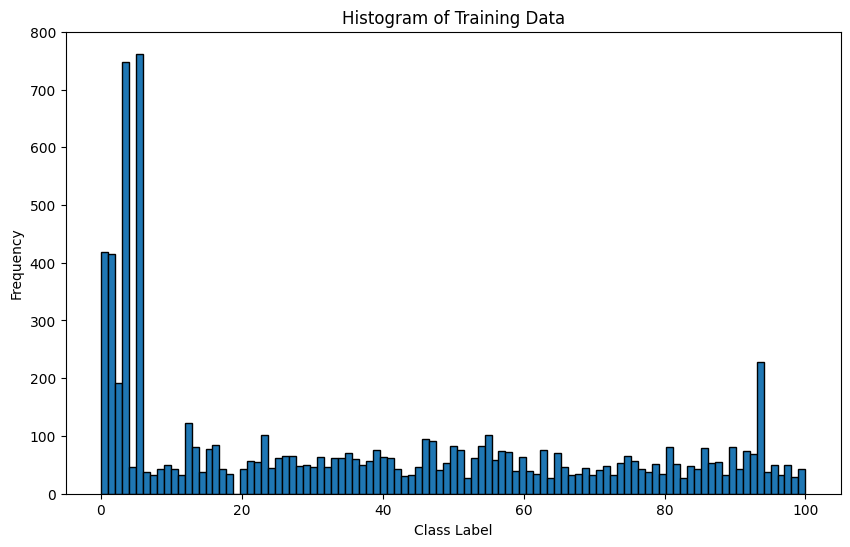

In [6]:
#########################################
## TODO: plot a histogram of the labels in `train_labels`.
# The histogram should have 101 bins, one for each class.
#########################################
# Your code goes here:
plt.figure(figsize=(10, 6))
plt.hist(train_labels, bins=101, edgecolor='black')
plt.title("Histogram of Training Data")
plt.xlabel("Class Label")
plt.ylabel("Frequency")
plt.show

Insights on histogram: Frequency representing the number of images that belong to each class label. The frequency average starts off relatively high, and in the whole histogram, there are only 5 classes with a frequency greater than 200. There is a class imbalance, as the frequencies are significantly higher than the majority of other classes (most having a freqency of less than 100), which could potentially lead to them being overly represented in the model, resulting in poorer performance for the majority of the classes.

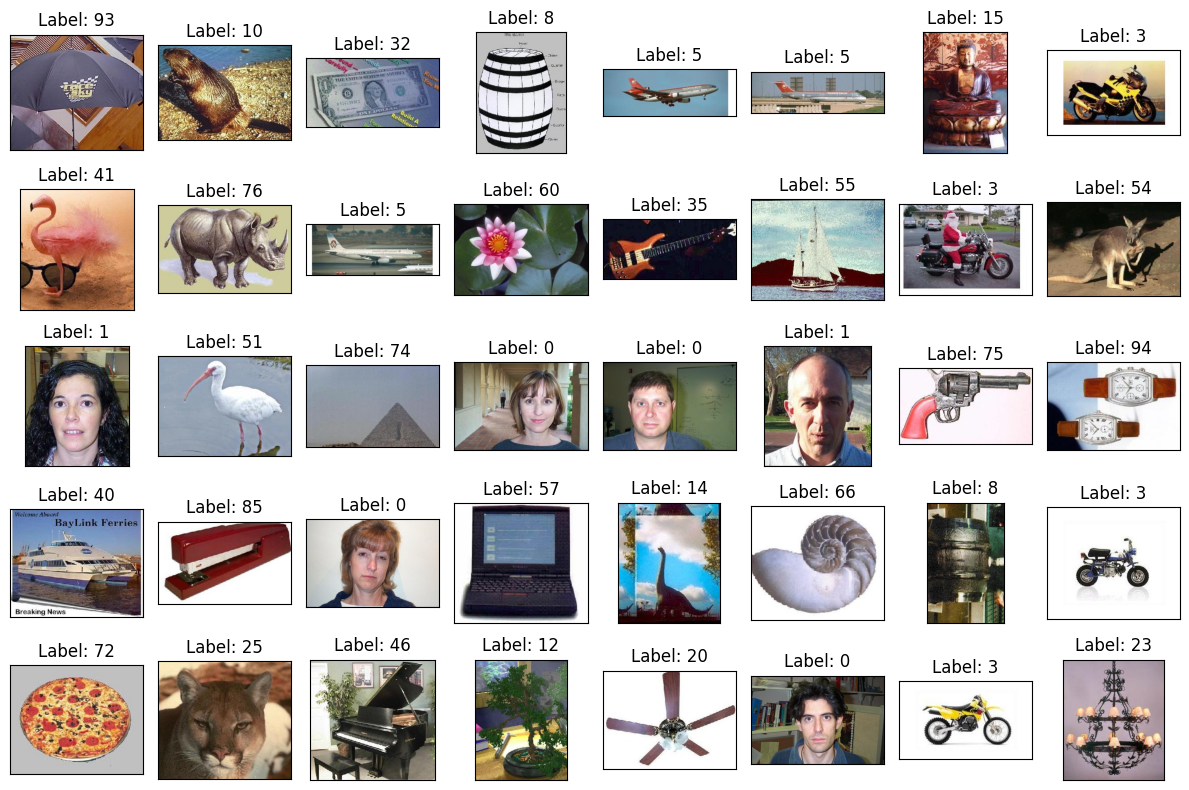

In [7]:
rows, cols = 5, 8
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))

random_idx= random.sample(range(len(train_images)), (rows * cols))
random_images = [train_images[i] for i in random_idx]
random_labels = [train_labels[i] for i in random_idx]

for i, ax in enumerate(axes.flat):
    ax.imshow(random_images[i].permute(1, 2, 0))    
    ax.set_title(f"Label: {random_labels[i]}")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [8]:
# detect if a GPU is available (make sure it prints cuda)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

# load a pre-trained CLIP model (and send it to the GPU if available)
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32", device_map='auto')

# load a pre-trained CLIP processor, the role of the processor is to
# encode the images and texts into the input format expected by the model
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

cuda


In [9]:
# due to memory constraints we will split the images
# into batches using the function below and then
# concatenate the outputs
def process_images_batch(proc, nnet, imgs, batch_size, dev):
    n_batches = int(np.ceil(len(imgs)/batch_size))
    embeddings = []
    for i in tqdm(range(n_batches)):
        # clear memory before each batch
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()
        # calculate first and last indices for the batch
        start_idx = i * batch_size
        end_idx = min((i+1)*batch_size, len(imgs))
        # send the batch of images through the processor
        inputs = proc(images=imgs[start_idx:end_idx], return_tensors="pt", padding=True, do_rescale=False, do_resize=True, do_center_crop=True)
        inputs = {k: v.to(dev) for k, v in inputs.items()}
        # send the batch of processed images through the CLIP model
        with torch.no_grad():
            embeddings.append(nnet.get_image_features(**inputs).cpu())
    return torch.cat(embeddings, dim=0)

# use the function to get the embeddings
train_embeddings = process_images_batch(processor, model, train_images, 256, device)
test_embeddings = process_images_batch(processor, model, test_images, 256, device)

print(f'\n\ntraining embeddings: {train_embeddings.shape}, test embeddings: {test_embeddings.shape}')

100%|██████████| 2/2 [00:09<00:00,  4.87s/it]



training embeddings: torch.Size([7886, 512]), test embeddings: torch.Size([410, 512])


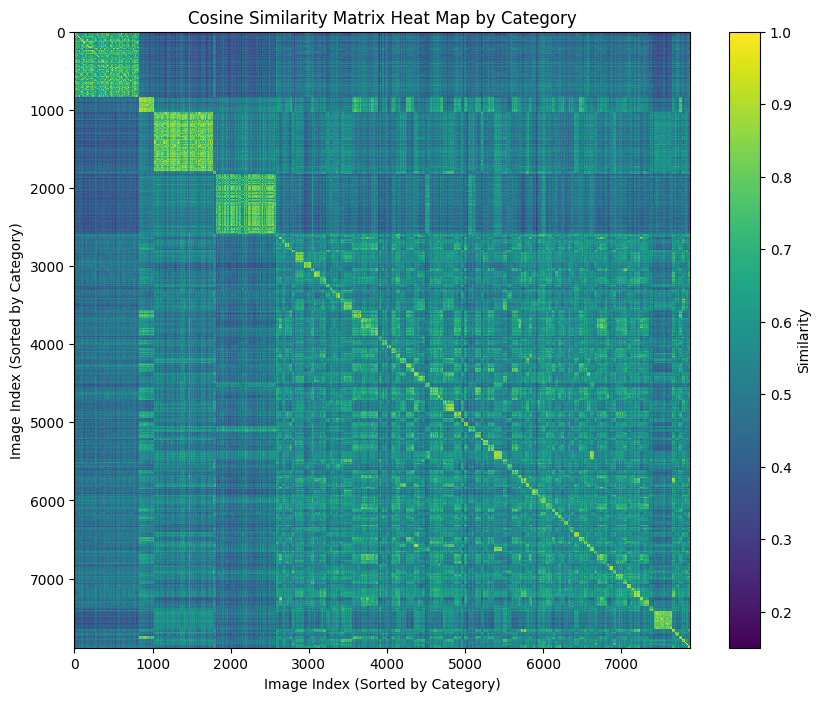

Similarity matrix shape: torch.Size([7886, 7886])
Similarity range: [0.150, 1.000]


In [13]:
#########################################
## TODO:
# 1. Use the `argsort` function to obtain a list of indices that correspond to the
# sorted order of the training images by their category
# 2. Calculate the cosine similarity matrix between for all training embeddings, using
# the order of the sorted indices. The similarity matrix must have shape [N, N] where
# N is the number of training embeddings, and its elements should be in the range [0, 1].
# 3. Use the `imshow` function to display the similarity matrix as an image (heatmap) and use the
# `colorbar` function to add a colorbar to the plot. Add a title to the plot.
#########################################


#Normalize, to simplify cosine similarity matrix and allows for dot product of two vectors.
normalized_embeddings = torch.nn.functional.normalize(train_embeddings, p=2, dim=1)

#Sort labels + get indices
sorted_indices = torch.argsort(torch.tensor(train_labels))

#Order normalized embeddings
sorted_embeddings = normalized_embeddings[sorted_indices]

#Similarity matrix
similarity_matrix = torch.mm(sorted_embeddings, sorted_embeddings.T)

#Numpy for visualization
similarity_matrix_np = similarity_matrix.cpu().numpy()

# Plot the heat map
plt.figure(figsize=(10, 8))
im = plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
plt.colorbar(im, label='Similarity')  # Add a color bar to show the scale
plt.title("Cosine Similarity Matrix Heat Map by Category")
plt.xlabel("Image Index (Sorted by Category)")
plt.ylabel("Image Index (Sorted by Category)")
plt.tight_layout
plt.show()

print(f"Similarity matrix shape: {similarity_matrix.shape}")
print(f"Similarity range: [{similarity_matrix_np.min():.3f}, {similarity_matrix_np.max():.3f}]")

TODO: Provide a clear explanation of the plot. What do you observe? Are there any square patterns near the main diagonal in the plot? What do these patterns and their colors represent?

On the diagonal there are 3 major blocks, the first at ~850 x 850, the second at ~1000-2000 range, and the third at ~1800-2600 range. The presence of these block with a green/yellow indicate a higher similarity to each other, compared to images from different categories. We also see 2 minor blocks, one < 1000 range, and one close to 8000 range, these have a brighter yellow-green color (solid yellow is perfect similarity), again indicating a high similarity. And the off diagonal regions are more blue with some instances of green, representing a lower similarity than those found on the diagonal, which makes sense as they are of different categories. I also notice that earlier categories start off with more distinct blocks, and we see a decline once we get to indexes > ~2600, which might be due to later categories having more visual overlap, and the earlier categories being more visually distinct.  

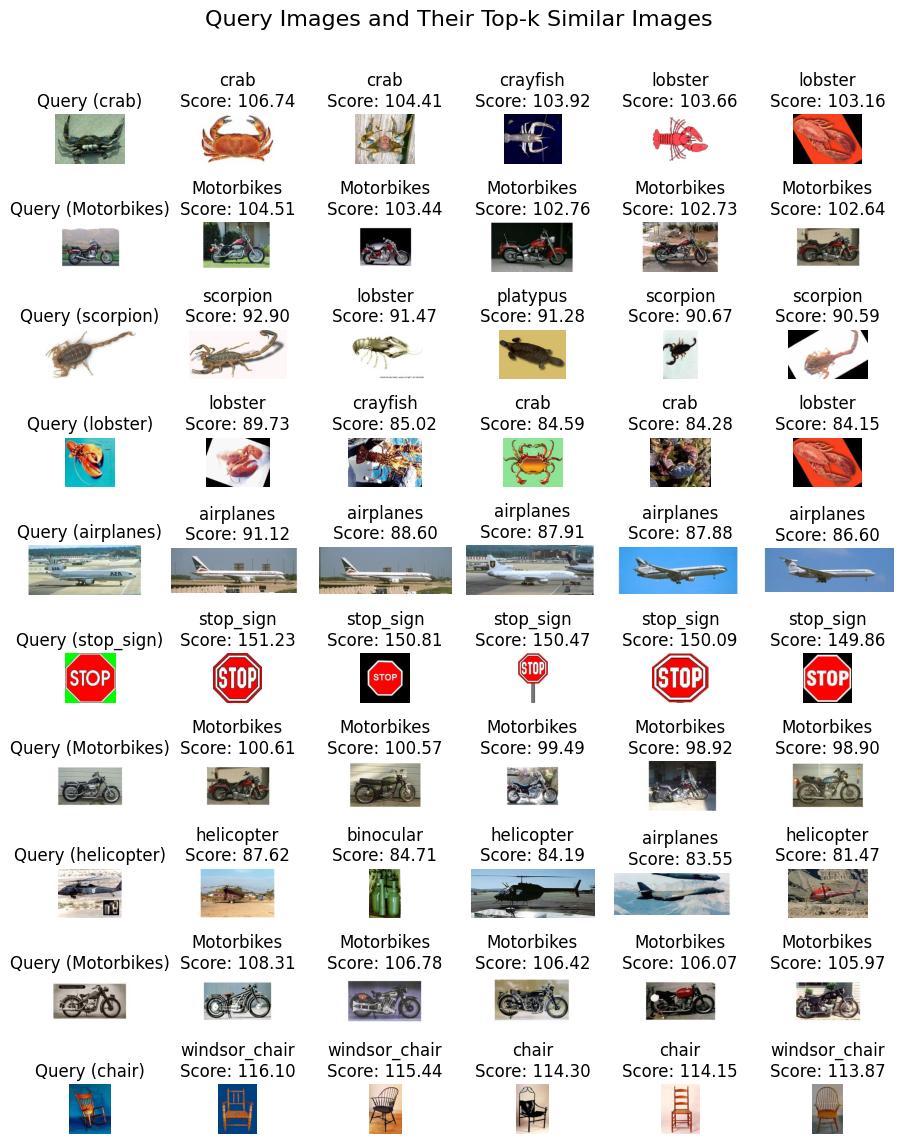

In [19]:
#########################################
## TODO:
# 1. Define a variable `k` with a value of 5, and a variable `M` with a value of 10.
# 2. Randomly select `M` embeddings from `test_embeddings` and store them in a variable `query`.
# 3. Calculate the similarity matrix between all training embeddings and the selected query
#  embeddings. It should have shape [N, M] where N is the number of training embeddings and M
#  is the number of query embeddings.
# 4. Use `plt.subplots` to display a grid of `M` rows and `k+1` columns (with `figsize=(9,12)`).
#  In the `i`-th row, you will display the image corresponding to the `i`-th query
#  embedding, followed by the top `k` most similar training images, according to the values
#  found in the similarity matrix. Add a title to each image showing the category of the
#  image and the similarity score between the `i`-th query image and this training image.
# 5. Every time you run this cell, you should see a different random set of test images and their most
#  nearest training images. You can run the cell multiple times to see different results.
#########################################
# Your code goes here:
k = 5
M = 10

idx = random.sample(range(len(test_embeddings)), M)
query = test_embeddings[idx]
query_images = [test_images[i] for i in idx]
query_labels = [test_labels[i] for i in idx]

similarity_matrix = torch.mm(train_embeddings, query.T)

#display a grid of M rows and (k+1) columns
fig, axs = plt.subplots(M, k + 1, figsize=(9, 12))
fig.suptitle("Query Images and Their Top-k Similar Images", fontsize=16)

#Asked chatgpt to help with the plotting
for i in range(M):
    #sort indices of training images based on similarity to the query image
    sorted_indices = torch.argsort(similarity_matrix[:, i], descending=True)
    
    #plot the query image in the first column
    axs[i, 0].imshow(query_images[i].permute(1, 2, 0))  
    axs[i, 0].set_title(f"Query ({categories[query_labels[i]]})")
    axs[i, 0].axis("off")
    
    #display the top k similar images in the remaining columns
    for j in range(1, k + 1):
        # retrieve the j-th most similar image and its similarity score
        img_index = sorted_indices[j - 1]
        similar_image = train_images[img_index]
        similarity_score = similarity_matrix[img_index, i].item()
        category = categories[train_labels[img_index]]
        
        
        axs[i, j].imshow(similar_image.permute(1, 2, 0))
        axs[i, j].set_title(f"{category}\nScore: {similarity_score:.2f}")
        axs[i, j].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

TODO: Provide a clear explanation of your insights. What do you observe? What can you conclude about the quality of the embeddings, and the dataset in general? What are your thoughts on the performance of building a k-NN classifier that uses CLIP embeddings?

The quality of the CLIP embeddings is generally promising, though there are notable areas for improvement. For instance, queries related to crabs and lobsters often yield similar results that include various crustaceans, such as crayfish and crab, indicating a tendency towards generalization. The scorpion query is particularly problematic, returning misclassifications such as platypus and lobster, while the helicopter query generates matches with binoculars and airplanes. Although many other queries yield accurate results, these mistakes highlight a range of issues—from overly broad classifications to blatant misclassifications. Confidence scores for some incorrect matches range from 84 to 91, surpassing those for correct classifications (e.g., certain airplane matches). This suggests that while the embeddings are moderately effective for general similarity tasks—capturing broad visual similarities—they struggle with fine-grained distinctions; for example, a scorpion is fundamentally different from a platypus. The dataset is fairly robust, offering a diverse range of images for each category, but incorporating clearer and more distinct images could help mitigate confusion among similar categories. The k-NN classifier shows reasonable performance, but there is significant room for improvement. While it accurately identifies the majority of the k-most similar images, some misclassifications are quite drastic. The classifier tends to perform best with visually distinct categories, yet it encounters challenges when dealing with similar categories, such as air vehicles or animals with exoskeletons.

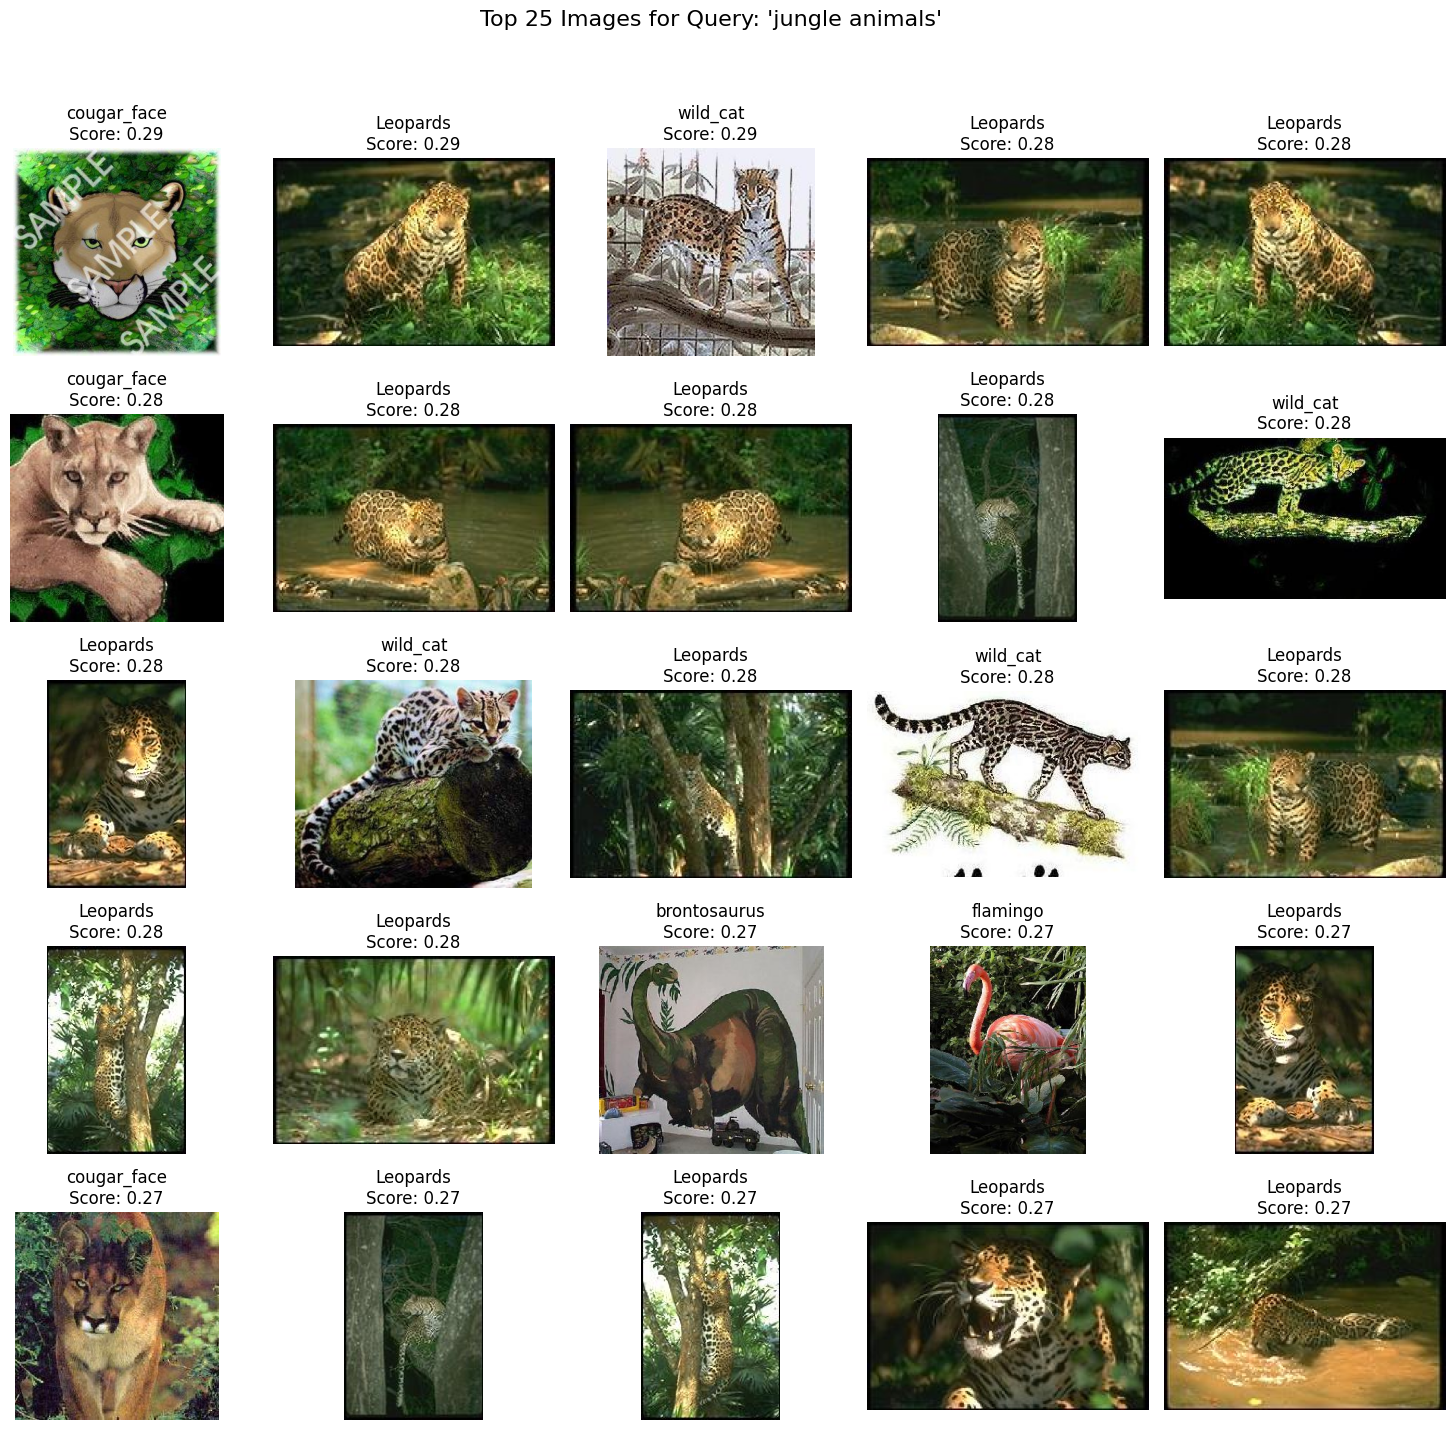

In [34]:
k = 25
# embedding a phrase using the clip model
phrase = "jungle animals"
inputs = processor(text=[phrase], return_tensors="pt", padding=True)
inputs.to(device)
with torch.no_grad():
    phrase_embedding = model.get_text_features(**inputs).cpu()

#########################################
## TODO:
# 1. Calculate the cosine similarity matrix between all training embeddings and the
# phrase embedding. The similarity matrix will be basically an array of N elements.
# 2. Find the top `k` indices for the nearest embeddings to the text query embedding
# using the similarity matrix and the `argsort` function.
# 3. Using `plt.subplots` display a grid of 5 rows and 5 columns. In each cell of the grid,
# display the image corresponding to one of the top `k` indices. Add a title to each
# image displaying the category of the image and the similarity score.
# Add a title to the plot with the phrase that was used as a query.
#########################################
# Your code goes here:

normalized_phrase_embeddings = torch.nn.functional.normalize(phrase_embedding, p=2, dim=1)
normalized_train_embeddings = torch.nn.functional.normalize(train_embeddings, p=2, dim=1)

similarity_matrix = torch.mm(normalized_train_embeddings, normalized_phrase_embeddings.T).squeeze()

#find top k indices
top_k_idx = torch.argsort(similarity_matrix, descending=True)[:k]

fig, axs = plt.subplots(5, 5, figsize=(15, 15))
fig.suptitle(f"Top {k} Images for Query: '{phrase}'", fontsize=16)

for i, idx in enumerate(top_k_idx):
    # Retrieve the corresponding image and similarity score
    similar_image = train_images[idx]
    similarity_score = similarity_matrix[idx].item()
    category = categories[train_labels[idx]]
    
    # Plot the image in the grid
    axs[i // 5, i % 5].imshow(similar_image.permute(1, 2, 0)) 
    axs[i // 5, i % 5].set_title(f"{category}\nScore: {similarity_score:.2f}")
    axs[i // 5, i % 5].axis("off")

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

TODO: Provide an explanation of what you observe in this plot. Are the images displayed similar to the query phrase? Which phrases you tried have failed? Which phrases did work surprisingly well? Be creative in trying any input query, share a list if you have some ones worthwile. Also provide any thoughts you have on this assignment.

I observed that with very specific queries, the model tends to fail, but when the query is more generalized, it performs pretty well, although the images tend to be very similar, for example for "jungle animals" it tend to be mostly big cats being displayed, but it still is technically accurate to the query phrase. 

Queries that failed: "Things that walk", "cars", "icecream", "snow"

Queries that worked surprisingly well: "Things that have wheels" "Things that fly" "mammals", "jungle animals"